In [4]:
"""
Deep Image Prior
https://arxiv.org/abs/1711.10925

test inpainting part

"""
print()

input_image.shape:  (512, 512, 3)


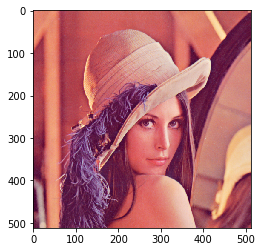

In [1]:
%matplotlib inline

import os, time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont

## load image
input_file = './pic_input/lenna_ori.png'
output_path = './pic_output/'

input_image = np.array(Image.open(input_file))[:, :, :3]
print('input_image.shape: ', input_image.shape)
plt.imshow(input_image)

In [2]:
## define function


def reflect_padding_layer(tf_input_image, kernel_size, stride):

    input_size = int(tf_input_image.get_shape()[1])
    output_size = int(np.ceil(input_size / stride))

    pad_size = int(np.ceil(((output_size - 1) * stride + kernel_size - input_size) * 0.5))
    tf_input_image = tf.pad(tf_input_image, 
                            [[0, 0], [pad_size, pad_size], [pad_size, pad_size], [0, 0]], 
                            "REFLECT")
    
    return tf_input_image


def downsampling_layer(tf_input_image, n_d=128, k_d=7):

    tf_input_image = reflect_padding_layer(tf_input_image, kernel_size=k_d, stride=2)
    tf_input_image = tf.contrib.layers.conv2d(inputs=tf_input_image, num_outputs=n_d, 
                                              kernel_size=k_d, stride=2, 
                                              padding='VALID', activation_fn=None)
    tf_input_image = tf.contrib.layers.batch_norm(inputs=tf_input_image, 
                                                  activation_fn=tf.nn.leaky_relu)

    tf_input_image = reflect_padding_layer(tf_input_image, kernel_size=k_d, stride=1)
    tf_input_image = tf.contrib.layers.conv2d(inputs=tf_input_image, num_outputs=n_d, 
                                              kernel_size=k_d, stride=1, 
                                              padding='VALID', activation_fn=None)
    tf_input_image = tf.contrib.layers.batch_norm(inputs=tf_input_image, 
                                                  activation_fn=tf.nn.leaky_relu)
    
    return tf_input_image


def upsampling_layer(tf_input_image, n_u=128, k_u=7):

    height, width = tf_input_image.get_shape()[1:3]
    tf_input_image = tf.image.resize_images(tf_input_image, [height*2, width*2], 
                                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    tf_input_image = reflect_padding_layer(tf_input_image, kernel_size=k_u, stride=1)
    tf_input_image = tf.contrib.layers.conv2d(inputs=tf_input_image, num_outputs=n_u, 
                                              kernel_size=k_u, stride=1, 
                                              padding='VALID', activation_fn=None)
    tf_input_image = tf.contrib.layers.batch_norm(inputs=tf_input_image, 
                                                  activation_fn=tf.nn.leaky_relu)

    # kernel_size=1
    tf_input_image = reflect_padding_layer(tf_input_image, kernel_size=1, stride=1)
    tf_input_image = tf.contrib.layers.conv2d(inputs=tf_input_image, num_outputs=n_u, 
                                              kernel_size=1, stride=1, 
                                              padding='VALID', activation_fn=None)
    tf_input_image = tf.contrib.layers.batch_norm(inputs=tf_input_image, 
                                                  activation_fn=tf.nn.leaky_relu)

    return tf_input_image



def skip_connections_layer(tf_input_image, n_s=0, k_s=0):

    tf_input_image = reflect_padding_layer(tf_input_image, kernel_size=k_s, stride=1)
    tf_input_image_sc = tf.contrib.layers.conv2d(inputs=tf_input_image, num_outputs=n_s, 
                                                 kernel_size=k_s, stride=1, 
                                                 padding='VALID', activation_fn=None)
    tf_input_image_sc = tf.contrib.layers.batch_norm(inputs=tf_input_image_sc, 
                                                     activation_fn=tf.nn.leaky_relu)

    ## use concat
    tf_input_image = tf.concat([tf_input_image, tf_input_image_sc], axis=3)

    return tf_input_image



def for_output_layer(tf_input_image, n_o=3, k_o=1):

    tf_input_image = reflect_padding_layer(tf_input_image, kernel_size=k_o, stride=1)
    tf_input_image = tf.contrib.layers.conv2d(inputs=tf_input_image, num_outputs=n_o, 
                                              kernel_size=k_o, stride=1, 
                                              padding='VALID', activation_fn=None)
    return tf_input_image


def image_save(path, img, reshape_size=[512, 512, 3]):
    img = np.array(img)
    img = img.reshape(reshape_size)
    img = np.clip(img, 0, 255).astype(np.uint8)
    Image.fromarray(img).save(path, quality=95)


def get_binary_text_mask(for_image, sz=20, position=(128, 128), text='hello world'):

    """
    refer from:
    https://github.com/DmitryUlyanov/deep-image-prior/blob/master/utils/inpainting_utils.py

    """

    font_fname = './font/FreeSansBold.ttf'
    font_size = sz
    font = ImageFont.truetype(font_fname, font_size)
    img_mask = Image.fromarray(np.array(for_image)*0+255)
    draw = ImageDraw.Draw(img_mask)
    draw.text(position, text, font=font, fill='rgb(0, 0, 0)')

    binary_mask_temp = np.array(img_mask)
    binary_mask = np.zeros_like(binary_mask_temp, dtype=np.float32)
    binary_mask += 1.0
    binary_mask[binary_mask_temp<254] -= 1.0

    return binary_mask


## build graph & run
def text_inpainting(input_image, n_u_list, n_d_list, k_u_list, k_d_list, n_s_list, k_s_list,
                    LR, num_iter, save_every_iter, show_every_iter, output_path, output_file_name,
                    image_normalize_TF, sigmoid_TF):

    output_temp_path = output_path + 'temp/'

    if not os.path.exists(output_path):
        os.makedirs(output_path) 
    if not os.path.exists(output_temp_path):
        os.makedirs(output_temp_path)   

    image_shape = [shape for shape in input_image.shape[:-1]]
    output_image_shape = [1] + image_shape + [32]

    ## get mask
    binary_mask_1 = get_binary_text_mask(input_image, sz=30, position=(128, 128), 
                                         text='Hello World')
    binary_mask_2 = get_binary_text_mask(input_image, sz=25, position=(250, 300), 
                                         text='on the face')
    binary_mask = np.multiply(binary_mask_1, binary_mask_2)

    corrupted_image = np.multiply(input_image, binary_mask)
    corrupted_image = corrupted_image.astype(np.uint8)

    ## show image
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(1,3,1)
    ax1.set_title('original_image')
    ax1.imshow(input_image)
    ax2 = fig.add_subplot(1,3,2)
    ax2.set_title('binary_mask')
    ax2.imshow(binary_mask)
    ax3 = fig.add_subplot(1,3,3)
    ax3.set_title('corrupted_image')
    ax3.imshow(corrupted_image)
    plt.show()
    fig.savefig(output_path+'all_image.png', bbox_inches='tight')

    image_save(path=output_path+'binary_mask.png', img=binary_mask)
    image_save(path=output_path+'corrupted_image.png', img=corrupted_image)

    ## graph  (can improve here !!)
    print('image_normalize_TF: ', image_normalize_TF)  
    print('sigmoid_TF: ', sigmoid_TF)  

    print('\nmodel structure: ')
    input_image_shape = [1] + image_shape + [3]
    input_image = corrupted_image
    if image_normalize_TF:
        input_image = input_image / 255
    input_image = np.reshape(input_image, input_image_shape)    
    input_image = tf.constant(input_image, dtype=tf.float32)

    ## placeholder
    output_image_point = tf.placeholder(shape=output_image_shape, dtype=tf.float32)
    tf_binary_mask = tf.placeholder(shape=input_image_shape[1:], dtype=tf.float32) 

    output_image = output_image_point

    ## downsampling
    for i in range(len(n_d_list)):
        output_image = downsampling_layer(tf_input_image=output_image, 
                                          n_d=n_d_list[i], k_d=k_d_list[i])
        print(output_image.get_shape())

    ## skip_connections
    output_image = skip_connections_layer(output_image, n_s=n_s_list[-1], k_s=k_s_list[-1])
    print(output_image.get_shape())

    ## upsampling   ** reversed !
    for i in reversed(range(len(n_u_list))):
        output_image = upsampling_layer(tf_input_image=output_image, 
                                        n_u=n_u_list[i], k_u=k_u_list[i])
        print(output_image.get_shape())

    ## for output
    output_image = for_output_layer(tf_input_image=output_image, n_o=3, k_o=1)
    print(output_image.get_shape())

    if sigmoid_TF:
        output_image = tf.sigmoid(output_image)

    ## loss, E()
    tf_binary_mask_ = tf.expand_dims(tf_binary_mask, 0)
    loss_E = tf.reduce_mean(tf.square(tf.multiply(tf.subtract(output_image, input_image), 
                                                  tf_binary_mask_)))
    optimizer = tf.train.AdamOptimizer(learning_rate=LR)
    train_op = optimizer.minimize(loss_E)

    ## GPU setting    
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())

        ## training
        print('\nGo Training...')
        training_start_time = time.time()
        iter_start_time = time.time()
        z = np.random.uniform(low=0.0, high=1/10, size=output_image_shape) 

        for i in range(num_iter+1):
            # z = np.random.uniform(low=0.0, high=1/10, size=output_image_shape)
            using_dict = {output_image_point: z, tf_binary_mask: binary_mask}

            ## run here
            sess.run(train_op, feed_dict=using_dict)

            if i % save_every_iter == 0:
                generate_image, training_loss = sess.run([output_image, loss_E], 
                                                         feed_dict=using_dict)
                generate_image = generate_image[0]

                if image_normalize_TF:
                    generate_image = generate_image * 255
                generate_image = np.clip(generate_image, 0, 255).astype(np.uint8)

                output_file = output_temp_path + output_file_name + '_' + str(i) + '.png'
                image_save(path=output_file, img=generate_image)
                print('iter: {:4d}/{:4d}, training loss: {:.8f}, use time: {:.3f}'.
                      format(i, num_iter, training_loss, time.time()-iter_start_time))
                iter_start_time = time.time()

            if i % show_every_iter == 0:
                fig = plt.figure(figsize=(8, 8))
                ax1 = fig.add_subplot(1,2,1)
                ax1.set_title('corrupted_image')
                ax1.imshow(corrupted_image)
                ax2 = fig.add_subplot(1,2,2)
                ax2.set_title('generate_image')
                ax2.imshow(generate_image)
                plt.show()

        output_file = output_path + output_file_name + '_' + str(i) + '_final.png'
        image_save(path=output_file, img=generate_image)
        print('training OK! (total using time: {})'.format(time.time()-training_start_time))

        plt.imshow(generate_image)
        plt.show()

        return generate_image



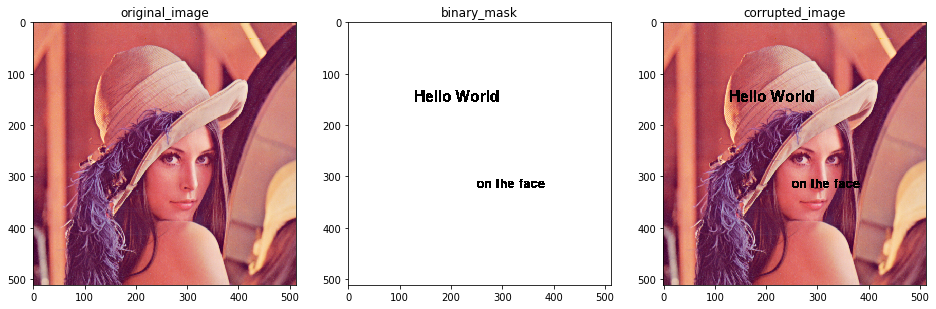

image_normalize_TF:  True
sigmoid_TF:  True

model structure: 
(1, 256, 256, 16)
(1, 128, 128, 32)
(1, 64, 64, 64)
(1, 32, 32, 128)
(1, 16, 16, 128)
(1, 16, 16, 132)
(1, 32, 32, 128)
(1, 64, 64, 128)
(1, 128, 128, 64)
(1, 256, 256, 32)
(1, 512, 512, 16)
(1, 512, 512, 3)

Go Training...
iter:    0/3000, training loss: 0.06470454, use time: 1.613


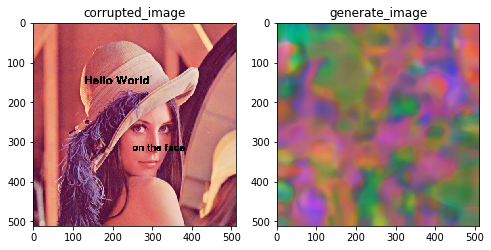

iter:   50/3000, training loss: 0.00999114, use time: 5.411
iter:  100/3000, training loss: 0.00678491, use time: 5.253
iter:  150/3000, training loss: 0.00473589, use time: 5.281
iter:  200/3000, training loss: 0.00419226, use time: 5.287
iter:  250/3000, training loss: 0.00411465, use time: 5.296
iter:  300/3000, training loss: 0.00369458, use time: 5.287
iter:  350/3000, training loss: 0.00294532, use time: 5.312
iter:  400/3000, training loss: 0.00300710, use time: 5.303
iter:  450/3000, training loss: 0.00249875, use time: 5.315
iter:  500/3000, training loss: 0.00242678, use time: 5.318


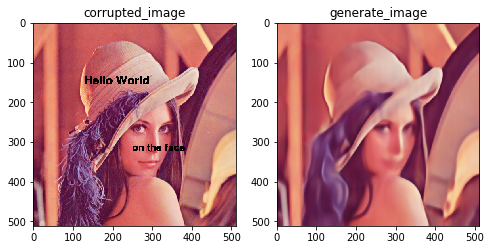

iter:  550/3000, training loss: 0.00241145, use time: 5.452
iter:  600/3000, training loss: 0.00219121, use time: 5.288
iter:  650/3000, training loss: 0.00213151, use time: 5.287
iter:  700/3000, training loss: 0.00202765, use time: 5.323
iter:  750/3000, training loss: 0.00196255, use time: 5.288
iter:  800/3000, training loss: 0.00184598, use time: 5.292
iter:  850/3000, training loss: 0.00174103, use time: 5.293
iter:  900/3000, training loss: 0.00163056, use time: 5.292
iter:  950/3000, training loss: 0.00152494, use time: 5.290
iter: 1000/3000, training loss: 0.00167676, use time: 5.303


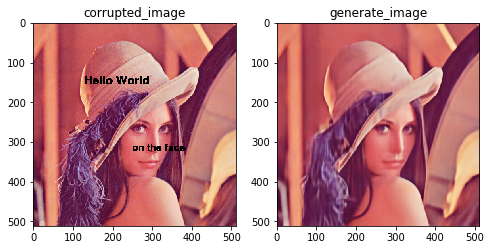

iter: 1050/3000, training loss: 0.00133189, use time: 5.543
iter: 1100/3000, training loss: 0.00136802, use time: 5.321
iter: 1150/3000, training loss: 0.00121626, use time: 5.338
iter: 1200/3000, training loss: 0.00137235, use time: 5.320
iter: 1250/3000, training loss: 0.00112192, use time: 5.329
iter: 1300/3000, training loss: 0.00116721, use time: 5.332
iter: 1350/3000, training loss: 0.00099531, use time: 5.337
iter: 1400/3000, training loss: 0.00098463, use time: 5.331
iter: 1450/3000, training loss: 0.00095803, use time: 5.329
iter: 1500/3000, training loss: 0.00090597, use time: 5.337


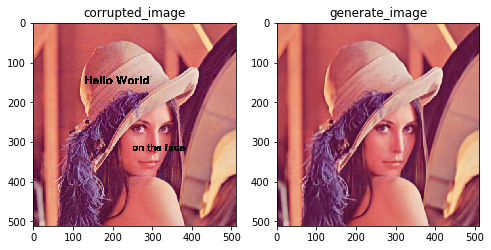

iter: 1550/3000, training loss: 0.00084937, use time: 5.494
iter: 1600/3000, training loss: 0.00107380, use time: 5.329
iter: 1650/3000, training loss: 0.00081938, use time: 5.335
iter: 1700/3000, training loss: 0.00076120, use time: 5.341
iter: 1750/3000, training loss: 0.00080390, use time: 5.321
iter: 1800/3000, training loss: 0.00079333, use time: 5.343
iter: 1850/3000, training loss: 0.00075691, use time: 5.341
iter: 1900/3000, training loss: 0.00070549, use time: 5.329
iter: 1950/3000, training loss: 0.00077815, use time: 5.336
iter: 2000/3000, training loss: 0.00067219, use time: 5.334


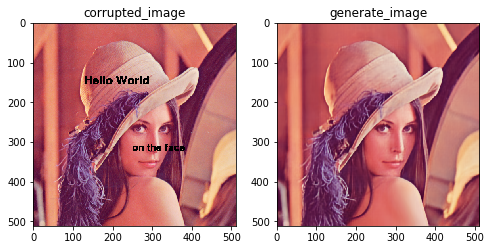

iter: 2050/3000, training loss: 0.00064456, use time: 5.495
iter: 2100/3000, training loss: 0.00061168, use time: 5.343
iter: 2150/3000, training loss: 0.00061993, use time: 5.345
iter: 2200/3000, training loss: 0.00062925, use time: 5.331
iter: 2250/3000, training loss: 0.00059345, use time: 5.331
iter: 2300/3000, training loss: 0.00057792, use time: 5.342
iter: 2350/3000, training loss: 0.00055290, use time: 5.332
iter: 2400/3000, training loss: 0.00058347, use time: 5.352
iter: 2450/3000, training loss: 0.00062243, use time: 5.343
iter: 2500/3000, training loss: 0.00054391, use time: 5.350


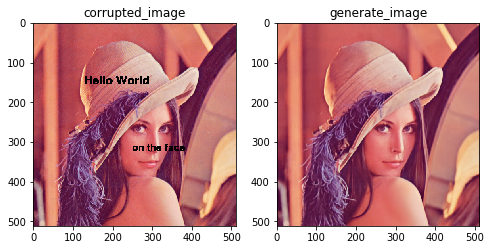

iter: 2550/3000, training loss: 0.00055145, use time: 5.511
iter: 2600/3000, training loss: 0.00055091, use time: 5.342
iter: 2650/3000, training loss: 0.00053707, use time: 5.336
iter: 2700/3000, training loss: 0.00071707, use time: 5.356
iter: 2750/3000, training loss: 0.00051817, use time: 5.350
iter: 2800/3000, training loss: 0.00050733, use time: 5.373
iter: 2850/3000, training loss: 0.00049445, use time: 5.353
iter: 2900/3000, training loss: 0.00050792, use time: 5.356
iter: 2950/3000, training loss: 0.00048277, use time: 5.331
iter: 3000/3000, training loss: 0.00081896, use time: 5.347


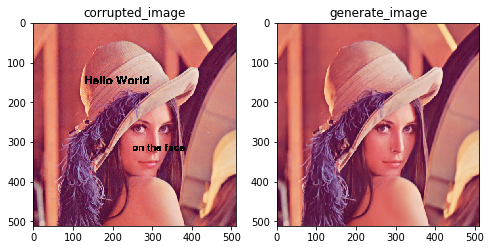

training OK! (total using time: 322.2540740966797)


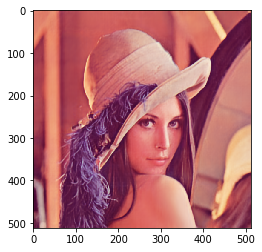

In [3]:
## run

## hyper-parameter
n_u_list = n_d_list = [16, 32, 64, 128, 128]
k_u_list = k_d_list = [7, 7, 7, 7, 7]
n_s_list = [0, 0, 0, 0, 4]
k_s_list = [0, 0, 0, 0, 1] 

LR = 0.01   ## learning rate
num_iter = 3000
save_every_iter = 50
show_every_iter = 500
output_path = './pic_output/'
output_file_name = 'lenna_ti'

## some TF setting
image_normalize_TF = True
sigmoid_TF = True


ok_image = text_inpainting(input_image, n_u_list, n_d_list, 
                           k_u_list, k_d_list, n_s_list, k_s_list, 
                           LR, num_iter, save_every_iter, 
                           show_every_iter, output_path, output_file_name, 
                           image_normalize_TF, sigmoid_TF)